In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score

from PIL import Image
import io, pickle
from tqdm import tqdm, trange
import numpy as np
import random

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('images/images.pickle', 'rb') as f:
    img_data = pickle.load(f)
class CustomDataset(Dataset):
    def __init__(self, img_data, txt_file, transform=None):
        self.data = img_data
        with open(txt_file, 'r') as f:
            self.labels = f.readlines()
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img_path, label = self.labels[idx].strip().split()
        img_path = img_path.split('/')
        img = self.data[img_path[1]][img_path[2]]
        img = Image.open(io.BytesIO(img)).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(int(label))
        open_channels = torch.tensor([1] * 3)
        return img, label, open_channels

class CustomDataset_Diff_CH(Dataset):
    def __init__(self, img_data, txt_file, transform=None):
        self.data = img_data
        with open(txt_file, 'r') as f:
            self.labels = f.readlines()
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img_path, label = self.labels[idx].strip().split()
        img_path = img_path.split('/')
        img = self.data[img_path[1]][img_path[2]]
        img = Image.open(io.BytesIO(img)).convert('RGB')
        if self.transform:
            img = self.transform(img)
        # 定義數字集合
        numbers = [0, 1, 2]
        open_channels = [1] * 3
        # 隨機挑選0到2個數字
        selected_numbers = random.sample(numbers, random.randint(0, 2))
        for i in selected_numbers:
            img[i, :, :] = 0
            open_channels[i] = 0
        label = torch.tensor(int(label))
        open_channels = torch.tensor(open_channels)
        return img, label, open_channels

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset_train = CustomDataset(img_data=img_data, txt_file='images/train.txt', transform=transform)
dataset_val = CustomDataset_Diff_CH(img_data=img_data, txt_file='images/val.txt', transform=transform)
dataset_test = CustomDataset_Diff_CH(img_data=img_data, txt_file='images/test.txt', transform=transform)


data_loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, )
data_loader_val = DataLoader(dataset_val, batch_size=32, shuffle=False)
data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)


In [3]:
x = torch.randn(2, 3, 2, 2)
y = torch.tensor([[[0], [1], [2]], [[1], [0], [1]]])
print(y.shape)
y_re = y.unsqueeze(-1)
print(y_re.shape)
print(x)
print(y)
print(y_re)
x*y.unsqueeze(-1)

torch.Size([2, 3, 1])
torch.Size([2, 3, 1, 1])
tensor([[[[ 1.5038, -1.5491],
          [ 0.3122,  0.4231]],

         [[-0.7638, -1.5407],
          [ 0.0029, -0.7098]],

         [[-0.1679, -0.2520],
          [-1.1628, -0.0553]]],


        [[[-0.5562,  0.2366],
          [ 1.6927,  0.4678]],

         [[-1.4281,  1.0966],
          [-0.3270, -0.3354]],

         [[ 0.2191,  0.5209],
          [ 0.2713,  0.9424]]]])
tensor([[[0],
         [1],
         [2]],

        [[1],
         [0],
         [1]]])
tensor([[[[0]],

         [[1]],

         [[2]]],


        [[[1]],

         [[0]],

         [[1]]]])


tensor([[[[ 0.0000, -0.0000],
          [ 0.0000,  0.0000]],

         [[-0.7638, -1.5407],
          [ 0.0029, -0.7098]],

         [[-0.3358, -0.5041],
          [-2.3255, -0.1105]]],


        [[[-0.5562,  0.2366],
          [ 1.6927,  0.4678]],

         [[-0.0000,  0.0000],
          [-0.0000, -0.0000]],

         [[ 0.2191,  0.5209],
          [ 0.2713,  0.9424]]]])

In [4]:
li = nn.Linear(4, 1)
x = torch.randn(2, 3, 2, 2).view(2, 3, -1)
print(x)
print(li.weight, li.bias)
print(x[:, 0, :].shape)
a = li(x[:, 0, :])
print(a)
print(a.shape)
z = torch.stack([a, a*2, a*3])
print(z.shape)
z_re = z.permute(1, 0, 2)
print(z_re.shape)
print(z_re)

tensor([[[ 2.1229, -1.0096,  0.2745, -0.4827],
         [-0.8081, -0.3678,  0.0040,  0.1729],
         [-0.0875, -0.2761,  0.8578,  0.1584]],

        [[ 2.3677, -0.3209, -0.3984, -1.9671],
         [ 0.1547, -0.6467,  0.0903, -0.7729],
         [ 0.1125, -0.5109, -1.1161,  1.8068]]])
Parameter containing:
tensor([[-0.2374, -0.1778,  0.3724,  0.3786]], requires_grad=True) Parameter containing:
tensor([0.1418], requires_grad=True)
torch.Size([2, 4])
tensor([[-0.2633],
        [-1.2564]], grad_fn=<AddmmBackward0>)
torch.Size([2, 1])
torch.Size([3, 2, 1])
torch.Size([2, 3, 1])
tensor([[[-0.2633],
         [-0.5266],
         [-0.7899]],

        [[-1.2564],
         [-2.5129],
         [-3.7693]]], grad_fn=<PermuteBackward0>)


In [5]:
import torch
import torch.nn.functional as F

# 创建一个形状为 (2, 3, 1) 的张量
x = torch.randn(2, 3, 1)

# 创建一个形状为 (2, 3) 的指示张量
# 值为 1 的位置表示要应用 Softmax 的 channel，值为 0 的位置表示不处理的 channel
mask = torch.tensor([[1, 0, 1], [0, 1, 1]])

# 将不处理的 channel 对应位置设置为一个非常小的数
masked_x = x.clone()  # 克隆 x，以保留原始张量
masked_x[mask == 0] = float('-inf')

# 在第 2 个维度上应用 Softmax
softmax_result = F.softmax(masked_x, dim=1)

# 将不处理的 channel 对应位置的概率置为零
softmax_result[mask == 0] = 0

print("Original tensor:")
print(x)

print("Mask tensor:")
print(mask)

print("After applying masked Softmax:")
print(softmax_result.unsqueeze(-1).shape)


Original tensor:
tensor([[[ 0.1367],
         [-1.1783],
         [-0.5429]],

        [[-0.7712],
         [-0.7203],
         [-0.4064]]])
Mask tensor:
tensor([[1, 0, 1],
        [0, 1, 1]])
After applying masked Softmax:
torch.Size([2, 3, 1, 1])


In [6]:
open_channels = torch.tensor([[1, 0, 1], [0, 1, 1]])
print(open_channels.shape)

torch.Size([2, 3])


In [7]:
# class CustomConv(nn.Module):
#     def __init__(self, out_channels, img_size, kernel_size):
#         super(CustomConv, self).__init__()
# 
#         self.linear_R = nn.Linear(img_size*img_size, 1)
#         self.linear_G = nn.Linear(img_size*img_size, 1)
#         self.linear_B = nn.Linear(img_size*img_size, 1)
# 
#         self.conv = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2)
#         
#     def forward(self, x, open_channels):
#         batch_size, channels, height, width = x.size()
#         # Flatten each channel
#         x_flattened = x.view(batch_size, channels, -1)  # Shape: (batch_size, channels, height*width)
#         weight_R = self.linear_R(x_flattened[:, 0, :])
#         weight_G = self.linear_G(x_flattened[:, 1, :])
#         weight_B = self.linear_B(x_flattened[:, 2, :])
#         kernel_weight = torch.stack([weight_R, weight_G, weight_B]).permute(1, 0, 2) #
#         kernel_weight_clone = kernel_weight.clone()
#         kernel_weight_clone[open_channels == 0] = float('-inf')
#         kernel_weight_clone = F.softmax(kernel_weight_clone, dim=1)
#         kernel_weight_clone[open_channels == 0] = 0
#         out = self.conv(x*kernel_weight_clone.unsqueeze(-1))
#         return out

class CustomConv(nn.Module):
    def __init__(self, out_channels, img_size, kernel_size):
        super(CustomConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        
    def forward(self, x, open_channels):
        batch_size, channels, height, width = x.size()
        # Flatten each channel        
        ones_count = open_channels.sum(dim=1, keepdim=True)  # Count the number of 1s in each row
        multiplier = (open_channels.float() / ones_count.float()) * 3  # Calculate the multiplier for each row
        multiplier = multiplier.view(multiplier.size(0), multiplier.size(1), 1, 1)  # Reshape for broadcasting
        
        out = self.conv(x * multiplier)

        return out

# class CustomConv(nn.Module):
#     def __init__(self, out_channels, img_size, kernel_size):
#         super(CustomConv, self).__init__()
#         self.conv_R = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2)
#         self.conv_G = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2)
#         self.conv_B = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2)
#     def forward(self, x, open_channels):
#         batch_size, channels, height, width = x.size()
#         # Flatten each channel        
#         ones_count = open_channels.sum(dim=1, keepdim=True)  # Count the number of 1s in each row
#         multiplier = (open_channels.float() / ones_count.float()) * 3  # Calculate the multiplier for each row
#         multiplier = multiplier.view(multiplier.size(0), multiplier.size(1), 1, 1)  # Reshape for broadcasting
#         
#         out = self.conv(x * multiplier)
# 
#         return out

# 示例使用
input_tensor = torch.randn(3, 3, 2, 2)  # batch_size=1, channels=3, height=32, width=32
model = CustomConv(out_channels=6, img_size=2, kernel_size=3)
output = model(input_tensor, torch.tensor([[1, 0, 0], [1, 0, 1], [1, 1, 1]]))
print(output.shape)  # 输出的形状

torch.Size([3, 6, 2, 2])


In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class CNNModel(nn.Module):

    def __init__(self, num_classes=50):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512*14*14, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout25 = nn.Dropout(0.25)
        self.dropout50 = nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.pool(self.activation(self.bn3(self.conv3(x))))
        x = self.pool(self.activation(self.bn4(self.conv4(x))))
        x = self.dropout25(self.flatten(x))
        x = self.dropout50(self.activation(self.fc1(x)))
        x = self.dropout50(self.activation(self.fc2(x)))
        # x = self.flatten(x)
        # x = self.gelu(self.fc1(x))
        # x = self.gelu(self.fc2(x))
        x = self.fc3(x)
        return x


for lr in [1e-4]:
    model = CNNModel(num_classes=50).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    num_epochs = 50
    save_path = 'record/Q1_diff_ch_not_weighted'
    model_path = f'{save_path}/model_weight/model_weight_lr{lr}_bn_dropout.pth'
    best_val_loss = float('inf')
    best_model = None
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        pbar = tqdm(data_loader_train, colour='green', total=len(data_loader_train))
        for images, labels, _ in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*len(labels)
            running_acc += (outputs.argmax(dim=1) == labels).float().sum().item()
            pbar.set_description(f'Train Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
            pbar.update()
        running_loss_avg = running_loss / len(dataset_train)
        running_acc_avg = running_acc / len(dataset_train)
        train_loss.append(running_loss_avg)
        train_acc.append(running_acc_avg)
        print(f"Epoch {epoch+1}, Loss: {running_loss_avg}, Accuracy: {running_acc_avg}")

        model.eval()
        with torch.no_grad():
            class_counts = [0] * 50
            running_loss = 0.0
            running_acc = 0.0
            pbar = tqdm(data_loader_val, colour='red', total=len(data_loader_val))
            for images, labels, _ in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predictions = outputs.argmax(dim=1)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*len(labels)
                running_acc += (predictions == labels).float().sum().item()
                pbar.set_description(f'Valid Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
                pbar.update()

                for pred_label in predictions:
                    class_counts[pred_label] += 1

            running_loss_avg = running_loss / len(dataset_val)
            running_acc_avg = running_acc / len(dataset_val)
            val_loss.append(running_loss_avg)
            val_acc.append(running_acc_avg)
            print(f"Validation Loss: {running_loss_avg}, Accuracy: {running_acc_avg}")
            print(f"Class Counts: {class_counts}")
            if running_loss_avg < best_val_loss:
                best_val_loss = running_loss
                best_model = model
                torch.save(model.state_dict(), model_path)
        print("======================================")
    print("Finished Training")


    model.eval()
    with torch.no_grad():
        class_counts = [0] * 50
        running_loss = 0.0
        running_acc = 0.0
        predictions = []
        true_labels = []
        pbar = tqdm(data_loader_test, colour='red', total=len(data_loader_test))
        for images, labels, _ in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            running_loss += loss.item()*len(labels)
            running_acc += (outputs.argmax(dim=1) == labels).float().sum().item()
            pbar.set_description(f'Test Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
            pbar.update()

        for pred_label in predictions:
            class_counts[pred_label] += 1
        
        precision = precision_score(true_labels, predictions, average='weighted')
        recall = recall_score(true_labels, predictions, average='weighted')
        f1 = f1_score(true_labels, predictions, average='weighted')
        print(f"Test Loss: {running_loss/len(dataset_test)}, Accuracy: {running_acc/len(dataset_test)}")
        print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")
        print(f"Class Counts: {class_counts}")
    print("Finished Testing")

    train_record = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
    test_record = {"true_labels": true_labels, "predictions": predictions, "precision": precision, "recall": recall, "f1": f1, "class_counts": class_counts}


    with open(f'{save_path}/train_record/train_record_lr{lr}_bn_dropout.pkl', 'wb') as f:
        pickle.dump(train_record, f)
    with open(f'{save_path}/test_record/test_record_lr{lr}_bn_dropout.pkl', 'wb') as f:
        pickle.dump(test_record, f)


Train Iter: 001/050  Loss: 3.0862: 100%|██████████| 1979/1979 [03:46<00:00,  8.75it/s]


Epoch 1, Loss: 3.6083999943309655, Accuracy: 0.08061587050927754


Valid Iter: 001/050  Loss: 2.6984: 100%|██████████| 15/15 [00:00<00:00, 23.57it/s]


Validation Loss: 3.853596280415853, Accuracy: 0.1
Class Counts: [11, 18, 6, 25, 27, 6, 4, 1, 0, 8, 6, 3, 0, 12, 5, 5, 3, 1, 4, 1, 2, 2, 1, 2, 1, 0, 0, 16, 24, 0, 0, 1, 4, 6, 0, 4, 0, 4, 1, 7, 54, 2, 5, 3, 10, 128, 7, 4, 10, 6]


Train Iter: 002/050  Loss: 3.0624: 100%|██████████| 1979/1979 [03:43<00:00,  8.87it/s]


Epoch 2, Loss: 3.1023032674853432, Accuracy: 0.1581997631267272


Valid Iter: 002/050  Loss: 3.4930: 100%|██████████| 15/15 [00:00<00:00, 24.42it/s]


Validation Loss: 4.078761631647746, Accuracy: 0.10888888888888888
Class Counts: [2, 1, 18, 18, 48, 2, 0, 19, 0, 0, 0, 0, 2, 3, 10, 3, 0, 1, 8, 0, 10, 0, 5, 1, 2, 9, 1, 19, 3, 8, 0, 0, 1, 11, 2, 6, 6, 0, 2, 9, 12, 4, 0, 4, 2, 139, 4, 6, 44, 5]


Train Iter: 003/050  Loss: 2.5630: 100%|██████████| 1979/1979 [03:43<00:00,  8.85it/s]


Epoch 3, Loss: 2.8753196027464325, Accuracy: 0.20664824318989342


Valid Iter: 003/050  Loss: 1.6407: 100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


Validation Loss: 4.022996322313944, Accuracy: 0.09111111111111111
Class Counts: [5, 1, 25, 48, 9, 2, 8, 40, 6, 2, 0, 0, 0, 6, 7, 11, 0, 1, 4, 1, 0, 7, 7, 0, 5, 2, 0, 6, 10, 1, 0, 2, 2, 2, 2, 2, 0, 1, 4, 15, 8, 4, 1, 2, 8, 128, 6, 4, 43, 2]


Train Iter: 004/050  Loss: 2.1798: 100%|██████████| 1979/1979 [03:45<00:00,  8.78it/s]


Epoch 4, Loss: 2.7044511425885767, Accuracy: 0.24816423213580735


Valid Iter: 004/050  Loss: 3.9093: 100%|██████████| 15/15 [00:00<00:00, 22.92it/s]


Validation Loss: 4.532492614322239, Accuracy: 0.12444444444444444
Class Counts: [4, 7, 14, 18, 13, 4, 1, 16, 6, 0, 0, 0, 1, 3, 4, 2, 1, 2, 1, 0, 6, 4, 0, 3, 4, 4, 1, 4, 1, 3, 0, 0, 4, 8, 4, 2, 5, 3, 1, 2, 19, 7, 1, 8, 5, 220, 4, 4, 21, 5]


Train Iter: 005/050  Loss: 2.4178: 100%|██████████| 1979/1979 [03:44<00:00,  8.82it/s]


Epoch 5, Loss: 2.5584531126236945, Accuracy: 0.2787682589814449


Valid Iter: 005/050  Loss: 3.2758: 100%|██████████| 15/15 [00:00<00:00, 24.19it/s]


Validation Loss: 5.501187839508057, Accuracy: 0.11777777777777777
Class Counts: [5, 5, 9, 33, 4, 3, 2, 5, 4, 0, 1, 1, 1, 1, 1, 3, 2, 2, 4, 3, 0, 1, 2, 4, 3, 1, 2, 5, 2, 1, 1, 1, 2, 0, 2, 5, 0, 6, 4, 4, 6, 5, 2, 6, 5, 262, 2, 1, 21, 5]


Train Iter: 006/050  Loss: 2.2745: 100%|██████████| 1979/1979 [03:41<00:00,  8.92it/s]


Epoch 6, Loss: 2.4268828894091463, Accuracy: 0.30853533359652585


Valid Iter: 006/050  Loss: 4.5389: 100%|██████████| 15/15 [00:00<00:00, 23.81it/s]


Validation Loss: 5.242903834448921, Accuracy: 0.13555555555555557
Class Counts: [8, 5, 9, 13, 5, 2, 6, 10, 6, 1, 2, 3, 2, 2, 0, 2, 1, 1, 6, 2, 8, 2, 4, 4, 0, 2, 3, 3, 5, 0, 0, 1, 5, 2, 2, 5, 2, 3, 4, 6, 5, 1, 3, 6, 8, 249, 4, 2, 21, 4]


Train Iter: 007/050  Loss: 2.1514: 100%|██████████| 1979/1979 [03:42<00:00,  8.90it/s]


Epoch 7, Loss: 2.319069512457985, Accuracy: 0.334496644295302


Valid Iter: 007/050  Loss: 2.0642: 100%|██████████| 15/15 [00:00<00:00, 23.85it/s]


Validation Loss: 4.629471955829197, Accuracy: 0.15333333333333332
Class Counts: [3, 3, 26, 19, 3, 4, 8, 17, 4, 3, 2, 0, 1, 7, 4, 3, 2, 3, 2, 4, 4, 4, 3, 1, 5, 0, 0, 2, 4, 4, 3, 0, 1, 3, 6, 2, 2, 4, 2, 9, 8, 2, 3, 3, 8, 209, 4, 16, 17, 3]


Train Iter: 008/050  Loss: 1.9804: 100%|██████████| 1979/1979 [03:43<00:00,  8.86it/s]


Epoch 8, Loss: 2.2099020159484555, Accuracy: 0.3613580734307146


Valid Iter: 008/050  Loss: 1.4434: 100%|██████████| 15/15 [00:00<00:00, 23.38it/s]


Validation Loss: 4.715638630125258, Accuracy: 0.1622222222222222
Class Counts: [6, 3, 30, 9, 3, 2, 9, 12, 5, 1, 1, 2, 6, 7, 2, 4, 1, 1, 4, 3, 2, 0, 4, 5, 3, 5, 0, 6, 2, 2, 0, 3, 4, 2, 3, 2, 2, 5, 3, 10, 5, 2, 4, 1, 3, 186, 4, 4, 66, 1]


Train Iter: 009/050  Loss: 2.0613: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 9, Loss: 2.101619105186568, Accuracy: 0.3851717331227793


Valid Iter: 009/050  Loss: 2.3841: 100%|██████████| 15/15 [00:00<00:00, 24.47it/s]


Validation Loss: 4.823146396213108, Accuracy: 0.16
Class Counts: [2, 4, 41, 6, 6, 0, 1, 11, 4, 11, 3, 5, 4, 2, 2, 0, 5, 1, 2, 3, 8, 2, 2, 0, 0, 1, 2, 3, 3, 4, 0, 0, 4, 3, 2, 4, 2, 5, 0, 12, 5, 5, 3, 3, 5, 177, 5, 14, 58, 5]


Train Iter: 010/050  Loss: 1.9963: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 10, Loss: 2.0062171631333765, Accuracy: 0.4089222266087643


Valid Iter: 010/050  Loss: 4.6337: 100%|██████████| 15/15 [00:00<00:00, 24.44it/s]


Validation Loss: 4.818455999162462, Accuracy: 0.13333333333333333
Class Counts: [3, 8, 19, 11, 7, 3, 0, 35, 3, 3, 0, 0, 7, 3, 2, 2, 4, 2, 3, 2, 2, 6, 2, 8, 3, 8, 2, 7, 2, 4, 1, 0, 4, 3, 4, 1, 1, 5, 0, 3, 4, 2, 0, 0, 8, 212, 4, 19, 17, 1]


Train Iter: 011/050  Loss: 1.7936: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 11, Loss: 1.9110791600159962, Accuracy: 0.4313462297670746


Valid Iter: 011/050  Loss: 1.6815: 100%|██████████| 15/15 [00:00<00:00, 24.31it/s]


Validation Loss: 4.2333343606525, Accuracy: 0.1688888888888889
Class Counts: [2, 4, 14, 14, 2, 5, 5, 17, 7, 29, 12, 2, 8, 0, 1, 2, 4, 4, 12, 1, 9, 1, 2, 5, 0, 4, 1, 3, 6, 4, 0, 3, 3, 1, 4, 3, 1, 4, 3, 8, 0, 4, 4, 3, 8, 116, 3, 20, 79, 3]


Train Iter: 012/050  Loss: 1.8250: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 12, Loss: 1.8217319781856485, Accuracy: 0.45236478484011056


Valid Iter: 012/050  Loss: 3.9649: 100%|██████████| 15/15 [00:00<00:00, 24.69it/s]


Validation Loss: 5.0726720873514815, Accuracy: 0.1688888888888889
Class Counts: [3, 2, 25, 15, 7, 7, 0, 4, 2, 6, 0, 0, 5, 6, 0, 6, 2, 4, 4, 5, 2, 7, 2, 1, 3, 3, 2, 8, 1, 4, 1, 6, 1, 0, 4, 5, 4, 4, 1, 5, 7, 1, 4, 4, 7, 183, 1, 16, 58, 2]


Train Iter: 013/050  Loss: 1.5069: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 13, Loss: 1.7324383424272474, Accuracy: 0.4763521515988946


Valid Iter: 013/050  Loss: 3.5085: 100%|██████████| 15/15 [00:00<00:00, 23.58it/s]


Validation Loss: 5.074603769514296, Accuracy: 0.16666666666666666
Class Counts: [7, 2, 40, 13, 3, 0, 2, 8, 1, 14, 3, 1, 4, 0, 4, 3, 2, 2, 5, 2, 4, 0, 2, 5, 3, 5, 1, 8, 1, 4, 1, 3, 5, 5, 4, 2, 2, 6, 6, 2, 12, 2, 1, 9, 4, 183, 4, 4, 42, 4]


Train Iter: 014/050  Loss: 1.9575: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 14, Loss: 1.6367260848755805, Accuracy: 0.4987761547572049


Valid Iter: 014/050  Loss: 3.1147: 100%|██████████| 15/15 [00:00<00:00, 24.30it/s]


Validation Loss: 4.166460908253987, Accuracy: 0.18888888888888888
Class Counts: [6, 7, 11, 24, 10, 3, 6, 30, 2, 13, 2, 2, 11, 7, 5, 3, 3, 4, 5, 4, 7, 4, 3, 6, 3, 10, 2, 6, 5, 4, 1, 2, 4, 1, 6, 6, 2, 2, 0, 8, 16, 2, 2, 1, 3, 104, 6, 1, 72, 3]


Train Iter: 015/050  Loss: 1.6457: 100%|██████████| 1979/1979 [03:39<00:00,  9.04it/s]


Epoch 15, Loss: 1.5594704289799663, Accuracy: 0.5174575602052902


Valid Iter: 015/050  Loss: 0.0712: 100%|██████████| 15/15 [00:00<00:00, 23.69it/s]


Validation Loss: 5.325151113271713, Accuracy: 0.18
Class Counts: [11, 5, 19, 9, 5, 2, 0, 4, 4, 10, 20, 1, 7, 4, 2, 4, 1, 4, 11, 3, 4, 5, 1, 2, 4, 7, 2, 3, 3, 1, 1, 3, 2, 1, 5, 4, 0, 2, 3, 4, 13, 0, 2, 4, 7, 158, 3, 4, 70, 6]


Train Iter: 016/050  Loss: 1.6257: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 16, Loss: 1.4697891402912855, Accuracy: 0.5419186735096724


Valid Iter: 016/050  Loss: 3.0950: 100%|██████████| 15/15 [00:00<00:00, 24.14it/s]


Validation Loss: 4.832041422526042, Accuracy: 0.20222222222222222
Class Counts: [9, 4, 21, 20, 9, 6, 7, 6, 5, 7, 6, 1, 3, 4, 2, 4, 1, 6, 8, 3, 2, 5, 1, 3, 1, 2, 2, 22, 2, 0, 3, 1, 3, 1, 3, 5, 4, 5, 5, 6, 12, 3, 6, 4, 5, 148, 3, 11, 44, 6]


Train Iter: 017/050  Loss: 1.4533: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 17, Loss: 1.3931507368422853, Accuracy: 0.5664587445716541


Valid Iter: 017/050  Loss: 5.1218: 100%|██████████| 15/15 [00:00<00:00, 24.66it/s]


Validation Loss: 4.702238693237304, Accuracy: 0.22
Class Counts: [7, 9, 17, 21, 6, 3, 2, 2, 6, 15, 8, 2, 6, 3, 5, 4, 4, 3, 4, 3, 5, 4, 2, 4, 0, 6, 8, 15, 4, 6, 3, 3, 2, 3, 4, 6, 5, 6, 4, 6, 5, 4, 0, 3, 12, 109, 2, 34, 52, 3]


Train Iter: 018/050  Loss: 0.9062: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 18, Loss: 1.3211033429207182, Accuracy: 0.5841294907224635


Valid Iter: 018/050  Loss: 3.1589: 100%|██████████| 15/15 [00:00<00:00, 24.24it/s]


Validation Loss: 5.0521996042463515, Accuracy: 0.21333333333333335
Class Counts: [7, 4, 10, 5, 6, 3, 3, 5, 3, 5, 2, 2, 4, 3, 6, 6, 3, 6, 7, 3, 4, 10, 2, 7, 3, 4, 3, 15, 1, 7, 1, 2, 8, 2, 3, 4, 5, 5, 1, 6, 13, 1, 3, 5, 5, 153, 5, 10, 65, 4]


Train Iter: 019/050  Loss: 1.0143: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 19, Loss: 1.2449440478751466, Accuracy: 0.6060955388866957


Valid Iter: 019/050  Loss: 0.0133: 100%|██████████| 15/15 [00:00<00:00, 22.98it/s]


Validation Loss: 5.329988845317728, Accuracy: 0.21555555555555556
Class Counts: [6, 2, 17, 10, 6, 1, 4, 4, 4, 5, 3, 4, 4, 3, 4, 3, 5, 3, 5, 3, 3, 6, 0, 2, 7, 6, 2, 7, 2, 4, 4, 7, 5, 6, 1, 7, 1, 7, 1, 11, 14, 2, 2, 2, 4, 159, 6, 11, 59, 6]


Train Iter: 020/050  Loss: 1.1351: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 20, Loss: 1.171007596585198, Accuracy: 0.62499802605606


Valid Iter: 020/050  Loss: 3.9755: 100%|██████████| 15/15 [00:00<00:00, 24.01it/s]


Validation Loss: 5.265112163755629, Accuracy: 0.2
Class Counts: [2, 6, 17, 13, 9, 5, 1, 8, 7, 28, 24, 6, 10, 4, 3, 2, 4, 4, 7, 3, 5, 1, 6, 3, 3, 4, 3, 8, 3, 2, 2, 6, 3, 4, 5, 2, 3, 7, 5, 5, 3, 5, 3, 2, 6, 100, 4, 12, 70, 2]


Train Iter: 021/050  Loss: 0.9458: 100%|██████████| 1979/1979 [03:40<00:00,  8.96it/s]


Epoch 21, Loss: 1.0941576824694625, Accuracy: 0.6471535728385314


Valid Iter: 021/050  Loss: 0.0108: 100%|██████████| 15/15 [00:00<00:00, 24.59it/s]


Validation Loss: 4.936648651320073, Accuracy: 0.21555555555555556
Class Counts: [7, 5, 31, 17, 11, 4, 5, 8, 8, 28, 4, 8, 4, 3, 5, 5, 4, 5, 1, 3, 3, 7, 5, 7, 1, 2, 3, 20, 1, 10, 3, 0, 4, 3, 3, 5, 0, 4, 2, 6, 5, 4, 5, 3, 3, 119, 4, 18, 30, 4]


Train Iter: 022/050  Loss: 0.6793: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 22, Loss: 1.0339782418142982, Accuracy: 0.663497828661666


Valid Iter: 022/050  Loss: 2.8069: 100%|██████████| 15/15 [00:00<00:00, 24.50it/s]


Validation Loss: 6.2853676329718695, Accuracy: 0.17555555555555555
Class Counts: [5, 6, 24, 23, 4, 5, 6, 9, 7, 19, 9, 1, 8, 3, 6, 3, 2, 3, 2, 5, 2, 3, 0, 4, 3, 7, 4, 4, 2, 4, 2, 2, 6, 1, 2, 2, 2, 2, 3, 6, 5, 3, 1, 1, 3, 119, 6, 19, 80, 2]


Train Iter: 023/050  Loss: 1.4469: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 23, Loss: 0.9715099174854928, Accuracy: 0.6828108961705488


Valid Iter: 023/050  Loss: 1.4813: 100%|██████████| 15/15 [00:00<00:00, 24.36it/s]


Validation Loss: 6.717543246481154, Accuracy: 0.18444444444444444
Class Counts: [6, 5, 10, 16, 6, 4, 1, 5, 4, 28, 6, 1, 4, 1, 2, 4, 2, 3, 5, 5, 4, 3, 1, 2, 1, 4, 4, 20, 5, 4, 3, 4, 4, 4, 3, 6, 2, 2, 2, 6, 9, 2, 3, 4, 4, 132, 8, 8, 74, 4]


Train Iter: 024/050  Loss: 1.0163: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 24, Loss: 0.9193664770713683, Accuracy: 0.7013343861034347


Valid Iter: 024/050  Loss: 3.6449: 100%|██████████| 15/15 [00:00<00:00, 24.29it/s]


Validation Loss: 5.468489500681559, Accuracy: 0.2088888888888889
Class Counts: [2, 10, 18, 12, 21, 3, 6, 9, 3, 13, 2, 1, 7, 3, 4, 4, 5, 3, 6, 2, 5, 3, 3, 4, 1, 5, 1, 22, 1, 3, 2, 3, 4, 1, 3, 8, 1, 2, 4, 8, 6, 1, 0, 7, 6, 116, 2, 30, 57, 7]


Train Iter: 025/050  Loss: 0.9674: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 25, Loss: 0.8646984753776246, Accuracy: 0.7170785629688117


Valid Iter: 025/050  Loss: 2.6379: 100%|██████████| 15/15 [00:00<00:00, 24.53it/s]


Validation Loss: 6.403068413204617, Accuracy: 0.2222222222222222
Class Counts: [5, 2, 14, 7, 9, 5, 6, 5, 3, 8, 4, 2, 4, 1, 5, 2, 5, 6, 6, 5, 2, 2, 3, 8, 2, 8, 8, 5, 3, 2, 2, 5, 2, 4, 3, 3, 3, 6, 4, 10, 8, 1, 1, 7, 7, 78, 4, 15, 136, 4]


Train Iter: 026/050  Loss: 1.0691: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 26, Loss: 0.8131840943857186, Accuracy: 0.7335807343071457


Valid Iter: 026/050  Loss: 0.6169: 100%|██████████| 15/15 [00:00<00:00, 24.04it/s]


Validation Loss: 6.292487443023258, Accuracy: 0.2222222222222222
Class Counts: [4, 5, 12, 24, 8, 6, 3, 5, 2, 32, 2, 10, 4, 2, 5, 3, 3, 4, 5, 2, 9, 5, 4, 3, 1, 3, 4, 9, 1, 3, 3, 3, 5, 4, 2, 6, 1, 8, 3, 5, 9, 2, 3, 3, 3, 111, 6, 10, 75, 5]


Train Iter: 027/050  Loss: 0.5919: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 27, Loss: 0.7717369384931285, Accuracy: 0.7433872878010265


Valid Iter: 027/050  Loss: 2.4727: 100%|██████████| 15/15 [00:00<00:00, 24.14it/s]


Validation Loss: 6.6485308774312335, Accuracy: 0.2111111111111111
Class Counts: [6, 8, 15, 6, 13, 3, 2, 5, 2, 18, 6, 5, 8, 5, 4, 4, 3, 3, 5, 6, 6, 6, 2, 6, 2, 7, 1, 11, 1, 5, 0, 4, 5, 4, 4, 4, 5, 3, 1, 10, 3, 2, 2, 2, 5, 95, 7, 11, 105, 4]


Train Iter: 028/050  Loss: 1.3738: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 28, Loss: 0.7325519034592379, Accuracy: 0.7597789182787209


Valid Iter: 028/050  Loss: 3.4876: 100%|██████████| 15/15 [00:00<00:00, 24.34it/s]


Validation Loss: 7.233054252200657, Accuracy: 0.18444444444444444
Class Counts: [3, 2, 11, 7, 8, 4, 3, 9, 4, 13, 3, 5, 5, 5, 3, 4, 4, 6, 6, 2, 4, 6, 3, 4, 4, 4, 6, 14, 3, 5, 3, 5, 6, 1, 2, 2, 0, 6, 2, 4, 7, 3, 1, 4, 9, 120, 3, 23, 87, 2]


Train Iter: 029/050  Loss: 0.9369: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 29, Loss: 0.686025390184495, Accuracy: 0.7741176470588236


Valid Iter: 029/050  Loss: 5.1660: 100%|██████████| 15/15 [00:00<00:00, 23.98it/s]


Validation Loss: 5.7977015622456864, Accuracy: 0.21555555555555556
Class Counts: [2, 7, 22, 19, 2, 3, 5, 8, 5, 23, 8, 4, 6, 2, 5, 1, 5, 6, 3, 5, 14, 5, 1, 5, 1, 3, 6, 15, 2, 10, 2, 4, 6, 6, 2, 2, 2, 7, 2, 12, 9, 2, 0, 7, 5, 85, 4, 6, 79, 5]


Train Iter: 030/050  Loss: 1.1518: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 30, Loss: 0.6486589023109673, Accuracy: 0.7861350177654954


Valid Iter: 030/050  Loss: 12.4473: 100%|██████████| 15/15 [00:00<00:00, 24.37it/s]


Validation Loss: 7.552487475077311, Accuracy: 0.19333333333333333
Class Counts: [2, 8, 20, 10, 8, 2, 2, 15, 5, 13, 4, 1, 3, 6, 3, 4, 1, 5, 4, 3, 4, 5, 1, 5, 4, 4, 4, 15, 8, 7, 3, 5, 4, 1, 5, 1, 1, 6, 3, 6, 6, 6, 2, 4, 5, 123, 3, 12, 73, 5]


Train Iter: 031/050  Loss: 0.6272: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 31, Loss: 0.6090062113143313, Accuracy: 0.7985945519147256


Valid Iter: 031/050  Loss: 2.3469: 100%|██████████| 15/15 [00:00<00:00, 23.00it/s]


Validation Loss: 6.516356592178345, Accuracy: 0.20222222222222222
Class Counts: [5, 5, 17, 15, 5, 2, 3, 4, 7, 9, 11, 1, 7, 3, 7, 5, 1, 5, 3, 1, 6, 7, 2, 3, 1, 6, 8, 14, 5, 1, 3, 7, 5, 3, 2, 3, 3, 3, 2, 8, 5, 1, 2, 6, 10, 80, 4, 11, 120, 3]


Train Iter: 032/050  Loss: 0.5895: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 32, Loss: 0.5890909021615135, Accuracy: 0.8060955388866956


Valid Iter: 032/050  Loss: 0.0011: 100%|██████████| 15/15 [00:00<00:00, 23.98it/s]


Validation Loss: 7.053183683470513, Accuracy: 0.21555555555555556
Class Counts: [4, 1, 14, 16, 12, 0, 9, 12, 2, 43, 6, 3, 7, 4, 2, 6, 3, 7, 5, 4, 5, 5, 2, 3, 4, 8, 7, 7, 3, 8, 1, 4, 3, 1, 3, 6, 2, 4, 2, 7, 5, 3, 3, 1, 8, 104, 3, 12, 62, 4]


Train Iter: 033/050  Loss: 0.3703: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 33, Loss: 0.5509605549114098, Accuracy: 0.8163758389261745


Valid Iter: 033/050  Loss: 3.1490: 100%|██████████| 15/15 [00:00<00:00, 24.19it/s]


Validation Loss: 6.566074438095093, Accuracy: 0.20222222222222222
Class Counts: [2, 3, 24, 17, 8, 2, 0, 4, 5, 43, 1, 4, 7, 4, 3, 2, 3, 5, 2, 1, 3, 8, 2, 3, 5, 8, 2, 23, 5, 7, 4, 2, 4, 3, 1, 3, 2, 6, 5, 6, 6, 3, 1, 3, 12, 56, 2, 26, 95, 4]


Train Iter: 034/050  Loss: 0.6054: 100%|██████████| 1979/1979 [03:40<00:00,  8.97it/s]


Epoch 34, Loss: 0.5217175781129143, Accuracy: 0.8279352546387683


Valid Iter: 034/050  Loss: 11.9919: 100%|██████████| 15/15 [00:00<00:00, 23.76it/s]


Validation Loss: 7.26487676832411, Accuracy: 0.2088888888888889
Class Counts: [5, 6, 19, 19, 7, 2, 3, 4, 7, 26, 7, 1, 2, 3, 3, 6, 3, 3, 1, 5, 3, 10, 3, 3, 5, 11, 0, 11, 5, 3, 4, 3, 6, 4, 3, 1, 4, 2, 2, 4, 6, 2, 2, 4, 5, 137, 7, 14, 49, 5]


Train Iter: 035/050  Loss: 0.5566: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 35, Loss: 0.5011225942119609, Accuracy: 0.83499407816818


Valid Iter: 035/050  Loss: 0.5392: 100%|██████████| 15/15 [00:00<00:00, 22.11it/s]


Validation Loss: 6.146165359550052, Accuracy: 0.18888888888888888
Class Counts: [4, 6, 24, 19, 11, 3, 2, 7, 6, 27, 4, 4, 4, 4, 3, 2, 5, 5, 6, 4, 5, 4, 1, 3, 2, 1, 10, 27, 10, 13, 3, 6, 3, 3, 2, 5, 2, 9, 0, 4, 10, 1, 1, 5, 9, 64, 1, 15, 78, 3]


Train Iter: 036/050  Loss: 0.9305: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 36, Loss: 0.4765218897332705, Accuracy: 0.8422424003158311


Valid Iter: 036/050  Loss: 3.7403: 100%|██████████| 15/15 [00:00<00:00, 24.10it/s]]


Validation Loss: 7.815528452131483, Accuracy: 0.2
Class Counts: [8, 2, 15, 43, 3, 5, 7, 12, 5, 31, 6, 4, 8, 2, 4, 5, 4, 3, 4, 5, 3, 4, 0, 3, 5, 4, 4, 8, 9, 0, 0, 2, 1, 3, 2, 2, 2, 1, 5, 5, 5, 0, 5, 4, 7, 94, 9, 20, 64, 3]


Train Iter: 037/050  Loss: 0.4715: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 37, Loss: 0.45008424508209244, Accuracy: 0.8516383734701934


Valid Iter: 037/050  Loss: 0.0001: 100%|██████████| 15/15 [00:00<00:00, 24.02it/s]


Validation Loss: 6.687477639235117, Accuracy: 0.24888888888888888
Class Counts: [3, 2, 10, 15, 6, 2, 6, 5, 6, 30, 11, 5, 8, 2, 7, 3, 3, 5, 6, 4, 1, 4, 2, 2, 0, 4, 8, 17, 3, 7, 3, 3, 5, 4, 3, 3, 1, 5, 5, 6, 8, 3, 3, 9, 13, 66, 5, 22, 90, 6]


Train Iter: 038/050  Loss: 0.2217: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 38, Loss: 0.4478053512346872, Accuracy: 0.8536123174101855


Valid Iter: 038/050  Loss: 2.0159: 100%|██████████| 15/15 [00:00<00:00, 24.27it/s]


Validation Loss: 8.00513940387302, Accuracy: 0.2311111111111111
Class Counts: [5, 4, 30, 16, 8, 3, 1, 7, 3, 13, 4, 2, 6, 1, 3, 1, 5, 7, 3, 3, 2, 3, 1, 5, 1, 6, 6, 11, 2, 5, 8, 2, 2, 3, 3, 5, 1, 3, 1, 6, 9, 3, 1, 5, 7, 90, 5, 19, 108, 2]


Train Iter: 039/050  Loss: 0.7195: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 39, Loss: 0.4227629547753543, Accuracy: 0.8624082116067904


Valid Iter: 039/050  Loss: 6.4946: 100%|██████████| 15/15 [00:00<00:00, 24.21it/s]


Validation Loss: 8.104092273712158, Accuracy: 0.18888888888888888
Class Counts: [11, 5, 15, 4, 4, 2, 9, 8, 6, 15, 2, 5, 3, 2, 5, 1, 6, 9, 1, 5, 4, 3, 3, 3, 3, 4, 6, 21, 3, 14, 1, 1, 8, 2, 2, 1, 4, 2, 2, 7, 10, 2, 1, 7, 7, 89, 3, 9, 109, 1]


Train Iter: 040/050  Loss: 0.2445: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 40, Loss: 0.3988881173220445, Accuracy: 0.8707935254638768


Valid Iter: 040/050  Loss: 4.6609: 100%|██████████| 15/15 [00:00<00:00, 22.68it/s]


Validation Loss: 6.54492783440484, Accuracy: 0.21333333333333335
Class Counts: [3, 6, 18, 22, 5, 3, 1, 11, 5, 12, 2, 2, 4, 3, 3, 2, 6, 7, 3, 5, 4, 3, 2, 3, 3, 6, 3, 16, 5, 3, 2, 2, 5, 2, 1, 3, 4, 4, 4, 5, 11, 1, 2, 6, 6, 111, 4, 12, 87, 7]


Train Iter: 041/050  Loss: 0.2115: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 41, Loss: 0.37727285130264915, Accuracy: 0.8777102250296092


Valid Iter: 041/050  Loss: 0.0004: 100%|██████████| 15/15 [00:00<00:00, 24.59it/s]


Validation Loss: 7.395774356845714, Accuracy: 0.21777777777777776
Class Counts: [8, 5, 12, 21, 4, 3, 1, 5, 1, 27, 7, 5, 4, 5, 4, 3, 4, 7, 5, 2, 6, 5, 1, 4, 3, 4, 5, 6, 6, 6, 1, 4, 3, 7, 3, 2, 2, 4, 4, 5, 9, 3, 3, 5, 10, 90, 5, 9, 97, 5]


Train Iter: 042/050  Loss: 0.2038: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 42, Loss: 0.36874551336049, Accuracy: 0.8816896960126333


Valid Iter: 042/050  Loss: 2.5520: 100%|██████████| 15/15 [00:00<00:00, 24.34it/s]


Validation Loss: 7.193294792175293, Accuracy: 0.19777777777777777
Class Counts: [4, 7, 19, 8, 9, 1, 5, 9, 5, 24, 5, 1, 5, 4, 3, 1, 2, 6, 0, 3, 4, 5, 3, 3, 2, 7, 10, 5, 2, 8, 3, 2, 6, 7, 3, 6, 0, 3, 1, 5, 9, 5, 3, 3, 8, 111, 2, 8, 86, 9]


Train Iter: 043/050  Loss: 0.3652: 100%|██████████| 1979/1979 [03:39<00:00,  9.04it/s]


Epoch 43, Loss: 0.35193896522363843, Accuracy: 0.8856533754441374


Valid Iter: 043/050  Loss: 0.9101: 100%|██████████| 15/15 [00:00<00:00, 24.47it/s]


Validation Loss: 6.6471121899286905, Accuracy: 0.2
Class Counts: [8, 6, 6, 7, 7, 5, 0, 6, 7, 37, 10, 3, 5, 3, 4, 3, 6, 5, 4, 2, 3, 4, 2, 4, 4, 6, 7, 7, 7, 9, 2, 4, 7, 3, 0, 1, 2, 8, 1, 8, 12, 2, 2, 4, 7, 63, 4, 21, 106, 6]


Train Iter: 044/050  Loss: 0.2767: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 44, Loss: 0.34549268521812654, Accuracy: 0.8883853138570864


Valid Iter: 044/050  Loss: 1.5126: 100%|██████████| 15/15 [00:00<00:00, 22.91it/s]


Validation Loss: 7.283999501864115, Accuracy: 0.21333333333333335
Class Counts: [6, 3, 18, 20, 4, 3, 1, 9, 4, 13, 5, 1, 2, 7, 2, 4, 3, 9, 0, 3, 6, 4, 6, 2, 1, 6, 8, 20, 9, 10, 6, 2, 6, 5, 1, 2, 0, 7, 3, 5, 8, 1, 3, 2, 5, 111, 3, 9, 74, 8]


Train Iter: 045/050  Loss: 0.2891: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 45, Loss: 0.3248862877849341, Accuracy: 0.8950651401500197


Valid Iter: 045/050  Loss: 2.5094: 100%|██████████| 15/15 [00:00<00:00, 24.32it/s]


Validation Loss: 6.532113270229764, Accuracy: 0.2311111111111111
Class Counts: [4, 7, 11, 12, 7, 3, 1, 5, 2, 77, 5, 14, 4, 3, 6, 4, 6, 4, 6, 2, 7, 1, 2, 4, 4, 6, 11, 35, 8, 5, 1, 7, 4, 3, 2, 3, 2, 2, 1, 6, 12, 0, 6, 3, 9, 48, 2, 6, 62, 5]


Train Iter: 046/050  Loss: 0.1480: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 46, Loss: 0.31517997279686744, Accuracy: 0.8981760757994472


Valid Iter: 046/050  Loss: 2.7149: 100%|██████████| 15/15 [00:00<00:00, 24.50it/s]


Validation Loss: 6.801247852113512, Accuracy: 0.19111111111111112
Class Counts: [5, 8, 10, 7, 12, 5, 3, 4, 1, 15, 6, 5, 10, 4, 6, 1, 2, 4, 2, 9, 7, 4, 1, 5, 2, 4, 4, 9, 3, 2, 3, 2, 3, 4, 4, 3, 5, 9, 5, 6, 5, 4, 4, 8, 13, 85, 5, 21, 95, 6]


Train Iter: 047/050  Loss: 0.1817: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 47, Loss: 0.3050825579609741, Accuracy: 0.9006079747335176


Valid Iter: 047/050  Loss: 1.8337: 100%|██████████| 15/15 [00:00<00:00, 24.78it/s]


Validation Loss: 6.342096333503723, Accuracy: 0.2311111111111111
Class Counts: [5, 4, 18, 16, 5, 3, 4, 8, 3, 47, 12, 9, 11, 4, 10, 3, 5, 5, 6, 3, 3, 3, 5, 4, 7, 4, 3, 9, 6, 3, 3, 6, 6, 3, 2, 0, 2, 6, 3, 6, 14, 1, 4, 3, 11, 49, 4, 8, 86, 5]


Train Iter: 048/050  Loss: 0.2829: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 48, Loss: 0.2907889988094839, Accuracy: 0.9065140150019739


Valid Iter: 048/050  Loss: 0.0025: 100%|██████████| 15/15 [00:00<00:00, 24.41it/s]


Validation Loss: 6.699946112677248, Accuracy: 0.24
Class Counts: [5, 4, 17, 11, 2, 6, 1, 6, 5, 37, 19, 2, 9, 5, 5, 4, 3, 4, 4, 4, 4, 4, 2, 4, 3, 10, 3, 16, 12, 5, 1, 4, 10, 5, 4, 3, 2, 4, 1, 8, 13, 4, 3, 4, 4, 77, 5, 10, 65, 7]


Train Iter: 049/050  Loss: 0.4481: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 49, Loss: 0.2868214918270066, Accuracy: 0.9078720884326885


Valid Iter: 049/050  Loss: 3.1780: 100%|██████████| 15/15 [00:00<00:00, 24.10it/s]]


Validation Loss: 8.282216662300957, Accuracy: 0.21777777777777776
Class Counts: [6, 5, 37, 23, 6, 2, 4, 11, 1, 40, 11, 8, 11, 3, 9, 1, 4, 5, 1, 2, 0, 4, 2, 3, 5, 5, 3, 6, 13, 1, 1, 3, 6, 2, 2, 0, 0, 8, 2, 5, 7, 2, 4, 6, 5, 70, 3, 15, 72, 5]


Train Iter: 050/050  Loss: 0.1069: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 50, Loss: 0.2759675045321452, Accuracy: 0.9111883142518753


Valid Iter: 050/050  Loss: 5.7532: 100%|██████████| 15/15 [00:00<00:00, 24.03it/s]]


Validation Loss: 6.815534799363878, Accuracy: 0.18444444444444444
Class Counts: [2, 8, 15, 16, 5, 2, 2, 11, 4, 43, 7, 6, 6, 5, 6, 1, 1, 4, 5, 3, 5, 5, 1, 4, 3, 3, 3, 10, 6, 4, 5, 2, 3, 5, 3, 3, 3, 6, 2, 6, 12, 4, 1, 5, 7, 79, 7, 4, 92, 5]
Finished Training


Test Iter: 050/050  Loss: 5.7532: 100%|██████████| 15/15 [00:00<00:00, 21.24it/s]
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 5.753195762634277, Accuracy: 0.20222222222222222
Precision: 0.31220431361365686, Recall: 0.20222222222222222, F1: 0.2058395613483959
Class Counts: [4, 6, 17, 13, 4, 2, 3, 14, 5, 29, 8, 5, 6, 4, 10, 5, 2, 2, 4, 1, 7, 3, 3, 8, 3, 4, 4, 5, 9, 1, 6, 5, 9, 3, 3, 4, 0, 8, 2, 6, 9, 6, 3, 4, 6, 75, 2, 6, 97, 5]
Finished Testing


In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class CNNModel_Diff_CH(nn.Module):

    def __init__(self, num_classes=50):
        super(CNNModel_Diff_CH, self).__init__()
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        ########## My Custom Conv module
        self.CustomConv1 = CustomConv(out_channels=64, img_size=224, kernel_size=3)
        ##########
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512*14*14, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout25 = nn.Dropout(0.25)
        self.dropout50 = nn.Dropout(0.5)
    def forward(self, x, open_channels):
        x = self.pool(self.activation(self.bn1(self.CustomConv1(x, open_channels))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.pool(self.activation(self.bn3(self.conv3(x))))
        x = self.pool(self.activation(self.bn4(self.conv4(x))))
        x = self.dropout25(self.flatten(x))
        x = self.dropout50(self.activation(self.fc1(x)))
        x = self.dropout50(self.activation(self.fc2(x)))
        # x = self.flatten(x)
        # x = self.gelu(self.fc1(x))
        # x = self.gelu(self.fc2(x))
        x = self.fc3(x)
        return x


for lr in [1e-4]:
    model = CNNModel_Diff_CH(num_classes=50).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    num_epochs = 50
    save_path = 'record/Q1_diff_ch'
    model_path = f'{save_path}/model_weight/model_weight_lr{lr}_bn_dropout.pth'
    best_val_loss = float('inf')
    best_model = None
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        pbar = tqdm(data_loader_train, colour='green', total=len(data_loader_train))
        for images, labels, open_channels in pbar:
            images, labels, open_channels = images.to(device), labels.to(device), open_channels.to(device)
            optimizer.zero_grad()
            outputs = model(images, open_channels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*len(labels)
            running_acc += (outputs.argmax(dim=1) == labels).float().sum().item()
            pbar.set_description(f'Train Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
            pbar.update()
        running_loss_avg = running_loss / len(dataset_train)
        running_acc_avg = running_acc / len(dataset_train)
        train_loss.append(running_loss_avg)
        train_acc.append(running_acc_avg)
        print(f"Epoch {epoch+1}, Loss: {running_loss_avg}, Accuracy: {running_acc_avg}")

        model.eval()
        with torch.no_grad():
            class_counts = [0] * 50
            running_loss = 0.0
            running_acc = 0.0
            pbar = tqdm(data_loader_val, colour='red', total=len(data_loader_val))
            for images, labels, open_channels in pbar:
                images, labels, open_channels = images.to(device), labels.to(device), open_channels.to(device)
                outputs = model(images, open_channels)
                predictions = outputs.argmax(dim=1)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*len(labels)
                running_acc += (predictions == labels).float().sum().item()
                pbar.set_description(f'Valid Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
                pbar.update()

                for pred_label in predictions:
                    class_counts[pred_label] += 1

            running_loss_avg = running_loss / len(dataset_val)
            running_acc_avg = running_acc / len(dataset_val)
            val_loss.append(running_loss_avg)
            val_acc.append(running_acc_avg)
            print(f"Validation Loss: {running_loss_avg}, Accuracy: {running_acc_avg}")
            print(f"Class Counts: {class_counts}")
            if running_loss_avg < best_val_loss:
                best_val_loss = running_loss
                best_model = model
                torch.save(model.state_dict(), model_path)
        print("======================================")
    print("Finished Training")


    model.eval()
    with torch.no_grad():
        class_counts = [0] * 50
        running_loss = 0.0
        running_acc = 0.0
        predictions = []
        true_labels = []
        pbar = tqdm(data_loader_test, colour='red', total=len(data_loader_test))
        for images, labels, open_channels in pbar:
            images, labels, open_channels = images.to(device), labels.to(device), open_channels.to(device)
            outputs = model(images, open_channels)

            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            running_loss += loss.item()*len(labels)
            running_acc += (outputs.argmax(dim=1) == labels).float().sum().item()
            pbar.set_description(f'Test Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
            pbar.update()

        for pred_label in predictions:
            class_counts[pred_label] += 1
        
        precision = precision_score(true_labels, predictions, average='weighted')
        recall = recall_score(true_labels, predictions, average='weighted')
        f1 = f1_score(true_labels, predictions, average='weighted')
        print(f"Test Loss: {running_loss/len(dataset_test)}, Accuracy: {running_acc/len(dataset_test)}")
        print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")
        print(f"Class Counts: {class_counts}")
    print("Finished Testing")

    train_record = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
    test_record = {"true_labels": true_labels, "predictions": predictions, "precision": precision, "recall": recall, "f1": f1, "class_counts": class_counts}


    with open(f'{save_path}/train_record/train_record_lr{lr}_bn_dropout.pkl', 'wb') as f:
        pickle.dump(train_record, f)
    with open(f'{save_path}/test_record/test_record_lr{lr}_bn_dropout.pkl', 'wb') as f:
        pickle.dump(test_record, f)


Train Iter: 001/050  Loss: 3.4773: 100%|██████████| 1979/1979 [03:38<00:00,  9.08it/s]


Epoch 1, Loss: 3.611327455504064, Accuracy: 0.07902092380576392


Valid Iter: 001/050  Loss: 5.6687: 100%|██████████| 15/15 [00:00<00:00, 23.95it/s]


Validation Loss: 7.01070617251926, Accuracy: 0.06
Class Counts: [7, 0, 25, 2, 25, 0, 1, 1, 0, 3, 0, 2, 0, 1, 0, 1, 0, 4, 1, 0, 8, 4, 4, 17, 3, 0, 0, 5, 2, 7, 2, 0, 0, 1, 5, 2, 3, 1, 0, 10, 13, 3, 0, 2, 3, 249, 12, 0, 21, 0]


Train Iter: 002/050  Loss: 3.3271: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 2, Loss: 3.1106865258335454, Accuracy: 0.15521515988945914


Valid Iter: 002/050  Loss: 1.5405: 100%|██████████| 15/15 [00:00<00:00, 23.90it/s]


Validation Loss: 5.348378030988905, Accuracy: 0.10666666666666667
Class Counts: [7, 0, 9, 12, 7, 5, 2, 3, 0, 2, 0, 0, 0, 7, 6, 4, 2, 1, 1, 2, 3, 0, 2, 6, 1, 8, 3, 10, 10, 5, 0, 0, 4, 3, 8, 3, 3, 2, 3, 7, 29, 6, 0, 9, 6, 180, 7, 4, 56, 2]


Train Iter: 003/050  Loss: 2.7629: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 3, Loss: 2.8919211605703037, Accuracy: 0.2008053691275168


Valid Iter: 003/050  Loss: 4.9121: 100%|██████████| 15/15 [00:00<00:00, 24.34it/s]


Validation Loss: 7.266010114881728, Accuracy: 0.11555555555555555
Class Counts: [12, 2, 10, 13, 5, 9, 1, 3, 5, 10, 0, 2, 1, 7, 4, 4, 0, 1, 9, 5, 2, 1, 0, 8, 9, 3, 0, 8, 12, 2, 4, 2, 4, 3, 4, 3, 4, 2, 0, 5, 11, 1, 1, 9, 2, 200, 10, 4, 28, 5]


Train Iter: 004/050  Loss: 2.4870: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 4, Loss: 2.7226829375497825, Accuracy: 0.23919463087248322


Valid Iter: 004/050  Loss: 3.2949: 100%|██████████| 15/15 [00:00<00:00, 24.79it/s]


Validation Loss: 5.686095627678765, Accuracy: 0.12666666666666668
Class Counts: [4, 0, 8, 6, 11, 6, 7, 14, 11, 1, 0, 2, 1, 3, 2, 1, 1, 5, 3, 7, 5, 4, 4, 5, 2, 8, 3, 13, 9, 1, 3, 4, 1, 1, 4, 0, 5, 5, 8, 8, 12, 2, 1, 6, 3, 168, 16, 11, 43, 2]


Train Iter: 005/050  Loss: 2.3073: 100%|██████████| 1979/1979 [03:37<00:00,  9.11it/s]


Epoch 5, Loss: 2.560239819764997, Accuracy: 0.2790525069088038


Valid Iter: 005/050  Loss: 5.1927: 100%|██████████| 15/15 [00:00<00:00, 24.41it/s]


Validation Loss: 6.915447510613335, Accuracy: 0.11777777777777777
Class Counts: [2, 7, 16, 7, 9, 5, 0, 13, 2, 0, 0, 0, 2, 9, 1, 2, 2, 1, 2, 3, 3, 2, 2, 4, 1, 5, 1, 15, 1, 1, 1, 0, 10, 2, 11, 2, 6, 4, 2, 3, 18, 4, 1, 0, 6, 210, 0, 13, 35, 4]


Train Iter: 006/050  Loss: 2.3387: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 6, Loss: 2.422755703412164, Accuracy: 0.31000394788788


Valid Iter: 006/050  Loss: 3.9260: 100%|██████████| 15/15 [00:00<00:00, 22.65it/s]


Validation Loss: 6.976438220342001, Accuracy: 0.1288888888888889
Class Counts: [11, 0, 5, 0, 5, 2, 5, 6, 8, 3, 4, 0, 2, 1, 0, 1, 4, 7, 4, 4, 1, 2, 2, 4, 0, 7, 2, 3, 5, 6, 1, 0, 0, 3, 8, 0, 5, 3, 1, 4, 19, 5, 1, 8, 2, 246, 7, 8, 16, 9]


Train Iter: 007/050  Loss: 2.1529: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 7, Loss: 2.3076931171326875, Accuracy: 0.33661271219897354


Valid Iter: 007/050  Loss: 3.6407: 100%|██████████| 15/15 [00:00<00:00, 24.30it/s]


Validation Loss: 6.995520743264092, Accuracy: 0.15777777777777777
Class Counts: [7, 5, 17, 10, 7, 3, 5, 4, 5, 3, 0, 3, 1, 3, 4, 6, 2, 1, 2, 7, 3, 1, 6, 2, 2, 2, 0, 4, 2, 1, 1, 0, 8, 8, 3, 2, 3, 1, 4, 5, 27, 3, 3, 2, 7, 184, 5, 9, 52, 5]


Train Iter: 008/050  Loss: 2.2483: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 8, Loss: 2.1937482732244975, Accuracy: 0.36260560600078956


Valid Iter: 008/050  Loss: 2.5294: 100%|██████████| 15/15 [00:00<00:00, 24.38it/s]


Validation Loss: 5.793246875339084, Accuracy: 0.16666666666666666
Class Counts: [9, 4, 19, 2, 6, 2, 3, 5, 2, 2, 13, 5, 6, 2, 1, 1, 3, 0, 5, 4, 4, 0, 0, 1, 4, 4, 1, 14, 3, 6, 2, 2, 6, 6, 2, 8, 5, 10, 7, 1, 28, 0, 1, 5, 10, 182, 5, 3, 34, 2]


Train Iter: 009/050  Loss: 1.9331: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 9, Loss: 2.079956598479523, Accuracy: 0.39085669166995657


Valid Iter: 009/050  Loss: 0.1748: 100%|██████████| 15/15 [00:00<00:00, 24.58it/s]


Validation Loss: 7.53019353972541, Accuracy: 0.13555555555555557
Class Counts: [6, 4, 18, 6, 5, 1, 1, 18, 10, 7, 0, 0, 2, 6, 3, 2, 1, 3, 2, 3, 4, 4, 1, 4, 5, 9, 5, 1, 4, 3, 0, 2, 1, 4, 7, 5, 2, 3, 3, 3, 29, 3, 0, 7, 8, 182, 1, 3, 46, 3]


Train Iter: 010/050  Loss: 1.6361: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 10, Loss: 1.9751567498375389, Accuracy: 0.4171022502960916


Valid Iter: 010/050  Loss: 10.1719: 100%|██████████| 15/15 [00:00<00:00, 23.90it/s]


Validation Loss: 9.097305119832356, Accuracy: 0.16444444444444445
Class Counts: [3, 1, 5, 8, 7, 1, 13, 8, 6, 10, 8, 0, 3, 5, 0, 2, 2, 5, 4, 2, 5, 7, 5, 1, 4, 1, 2, 7, 4, 2, 1, 4, 5, 0, 5, 3, 2, 4, 6, 5, 19, 0, 1, 3, 4, 213, 4, 6, 32, 2]


Train Iter: 011/050  Loss: 1.8800: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 11, Loss: 1.890573914631807, Accuracy: 0.43846821950256615


Valid Iter: 011/050  Loss: 2.6595: 100%|██████████| 15/15 [00:00<00:00, 22.92it/s]


Validation Loss: 7.490417090521919, Accuracy: 0.1711111111111111
Class Counts: [9, 4, 30, 10, 5, 4, 1, 0, 4, 7, 1, 1, 1, 5, 3, 1, 3, 3, 4, 5, 6, 2, 3, 3, 3, 2, 2, 23, 1, 4, 2, 2, 7, 2, 3, 3, 4, 8, 1, 4, 4, 2, 1, 3, 7, 194, 4, 3, 40, 6]


Train Iter: 012/050  Loss: 1.5928: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 12, Loss: 1.7914479364578872, Accuracy: 0.4598973549151204


Valid Iter: 012/050  Loss: 0.0470: 100%|██████████| 15/15 [00:00<00:00, 24.49it/s]


Validation Loss: 6.656352842268016, Accuracy: 0.18444444444444444
Class Counts: [5, 4, 2, 8, 21, 6, 5, 12, 2, 3, 2, 2, 5, 4, 1, 1, 6, 3, 4, 4, 2, 5, 2, 3, 0, 4, 8, 35, 1, 4, 1, 1, 6, 4, 5, 1, 3, 1, 4, 6, 13, 2, 0, 3, 11, 135, 2, 11, 72, 5]


Train Iter: 013/050  Loss: 1.2962: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 13, Loss: 1.6946428537218174, Accuracy: 0.48950651401500195


Valid Iter: 013/050  Loss: 6.7285: 100%|██████████| 15/15 [00:00<00:00, 24.49it/s]


Validation Loss: 8.080390540228949, Accuracy: 0.19555555555555557
Class Counts: [5, 3, 6, 3, 12, 2, 2, 14, 5, 4, 3, 4, 4, 3, 9, 1, 3, 5, 11, 2, 8, 3, 1, 3, 1, 5, 1, 5, 2, 4, 1, 1, 6, 5, 4, 5, 2, 8, 4, 7, 12, 2, 3, 8, 7, 198, 0, 2, 37, 4]


Train Iter: 014/050  Loss: 1.3524: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 14, Loss: 1.6073359586897924, Accuracy: 0.5106040268456375


Valid Iter: 014/050  Loss: 11.5265: 100%|██████████| 15/15 [00:00<00:00, 24.85it/s]


Validation Loss: 7.5955662239922415, Accuracy: 0.16
Class Counts: [10, 6, 5, 29, 12, 2, 6, 13, 6, 0, 7, 0, 0, 0, 3, 0, 2, 8, 2, 4, 3, 3, 2, 6, 4, 5, 1, 18, 1, 6, 0, 4, 7, 4, 9, 7, 1, 8, 5, 5, 6, 2, 3, 6, 5, 171, 1, 1, 36, 5]


Train Iter: 015/050  Loss: 1.5191: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 15, Loss: 1.5178234296855935, Accuracy: 0.5329648637978681


Valid Iter: 015/050  Loss: 9.2452: 100%|██████████| 15/15 [00:00<00:00, 24.76it/s]]


Validation Loss: 9.439585579766167, Accuracy: 0.19111111111111112
Class Counts: [3, 2, 15, 7, 6, 2, 3, 11, 7, 5, 4, 2, 4, 1, 4, 2, 5, 8, 9, 3, 4, 4, 2, 1, 8, 7, 3, 9, 2, 2, 4, 1, 6, 2, 7, 3, 4, 1, 1, 6, 7, 1, 1, 2, 5, 206, 6, 5, 33, 4]


Train Iter: 016/050  Loss: 1.1080: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 16, Loss: 1.4323293183248034, Accuracy: 0.5558626135017766


Valid Iter: 016/050  Loss: 20.6594: 100%|██████████| 15/15 [00:00<00:00, 24.30it/s]


Validation Loss: 9.678772498236762, Accuracy: 0.20222222222222222
Class Counts: [6, 6, 5, 14, 5, 5, 10, 8, 9, 9, 5, 3, 3, 1, 4, 1, 4, 7, 1, 1, 2, 3, 3, 4, 3, 6, 2, 8, 4, 5, 2, 3, 2, 2, 6, 1, 5, 2, 3, 5, 13, 0, 3, 9, 7, 192, 2, 2, 36, 8]


Train Iter: 017/050  Loss: 1.4376: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 17, Loss: 1.3465558573609513, Accuracy: 0.578255033557047


Valid Iter: 017/050  Loss: 11.8282: 100%|██████████| 15/15 [00:00<00:00, 23.46it/s]


Validation Loss: 6.672506412929959, Accuracy: 0.20444444444444446
Class Counts: [14, 8, 14, 34, 13, 3, 9, 21, 7, 10, 2, 4, 3, 6, 5, 4, 1, 1, 4, 0, 2, 4, 1, 2, 0, 7, 5, 30, 5, 4, 4, 4, 5, 2, 4, 4, 3, 4, 0, 7, 15, 1, 1, 1, 10, 101, 4, 4, 52, 1]


Train Iter: 018/050  Loss: 1.1213: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 18, Loss: 1.2616919303947507, Accuracy: 0.6017212791156731


Valid Iter: 018/050  Loss: 9.1804: 100%|██████████| 15/15 [00:00<00:00, 24.16it/s] 


Validation Loss: 10.040425470140246, Accuracy: 0.21333333333333335
Class Counts: [6, 7, 8, 10, 4, 3, 4, 7, 8, 11, 2, 7, 11, 2, 4, 1, 1, 5, 5, 6, 4, 1, 3, 2, 1, 5, 2, 14, 6, 4, 2, 2, 6, 1, 2, 3, 5, 5, 3, 6, 7, 2, 3, 5, 6, 187, 5, 3, 41, 2]


Train Iter: 019/050  Loss: 1.0477: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 19, Loss: 1.1904350946695965, Accuracy: 0.6219502566127122


Valid Iter: 019/050  Loss: 15.6314: 100%|██████████| 15/15 [00:00<00:00, 24.22it/s]


Validation Loss: 6.45205322265625, Accuracy: 0.20444444444444446
Class Counts: [10, 6, 7, 30, 7, 2, 7, 8, 5, 20, 10, 13, 1, 2, 6, 4, 4, 1, 5, 6, 4, 1, 5, 2, 1, 7, 3, 34, 5, 1, 0, 4, 8, 4, 5, 5, 0, 6, 1, 6, 17, 4, 3, 5, 3, 86, 1, 7, 65, 3]


Train Iter: 020/050  Loss: 1.0851: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 20, Loss: 1.107171214811895, Accuracy: 0.6450690880378998


Valid Iter: 020/050  Loss: 9.8253: 100%|██████████| 15/15 [00:00<00:00, 24.45it/s]]


Validation Loss: 9.613993877834744, Accuracy: 0.18888888888888888
Class Counts: [9, 4, 6, 23, 12, 1, 5, 9, 3, 1, 5, 3, 4, 6, 4, 1, 4, 2, 8, 2, 2, 0, 0, 3, 4, 2, 7, 12, 4, 6, 4, 4, 5, 1, 2, 7, 2, 6, 4, 8, 13, 3, 1, 4, 10, 164, 4, 1, 53, 2]


Train Iter: 021/050  Loss: 0.9659: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 21, Loss: 1.037022150521028, Accuracy: 0.6641926569285432


Valid Iter: 021/050  Loss: 15.6628: 100%|██████████| 15/15 [00:00<00:00, 24.50it/s]


Validation Loss: 9.593342853122287, Accuracy: 0.20666666666666667
Class Counts: [6, 4, 9, 15, 13, 6, 10, 4, 3, 9, 2, 1, 4, 7, 4, 1, 4, 5, 5, 0, 4, 5, 0, 6, 1, 7, 2, 26, 6, 9, 1, 3, 11, 4, 2, 1, 2, 4, 1, 3, 7, 3, 3, 6, 7, 152, 4, 7, 49, 2]


Train Iter: 022/050  Loss: 0.6826: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 22, Loss: 0.972282852478946, Accuracy: 0.6817686537702329


Valid Iter: 022/050  Loss: 18.8968: 100%|██████████| 15/15 [00:00<00:00, 24.39it/s]


Validation Loss: 10.42725121392144, Accuracy: 0.2
Class Counts: [11, 1, 10, 48, 4, 10, 2, 12, 6, 15, 3, 1, 5, 5, 2, 2, 1, 5, 8, 0, 1, 1, 1, 2, 2, 3, 4, 26, 11, 3, 1, 2, 6, 3, 3, 4, 4, 3, 1, 1, 11, 2, 1, 3, 10, 155, 6, 3, 25, 1]


Train Iter: 023/050  Loss: 1.2106: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 23, Loss: 0.9237268649604637, Accuracy: 0.6978602447690485


Valid Iter: 023/050  Loss: 3.9101: 100%|██████████| 15/15 [00:00<00:00, 23.97it/s]


Validation Loss: 7.144607383939955, Accuracy: 0.2288888888888889
Class Counts: [3, 3, 6, 22, 16, 5, 9, 8, 2, 12, 2, 2, 3, 5, 4, 2, 3, 5, 5, 5, 3, 7, 1, 1, 3, 8, 2, 31, 5, 4, 4, 3, 6, 4, 4, 3, 4, 4, 2, 8, 7, 3, 2, 5, 9, 55, 9, 19, 110, 2]


Train Iter: 024/050  Loss: 0.8088: 100%|██████████| 1979/1979 [03:37<00:00,  9.10it/s]


Epoch 24, Loss: 0.8557283436682589, Accuracy: 0.718231346229767


Valid Iter: 024/050  Loss: 0.0073: 100%|██████████| 15/15 [00:00<00:00, 24.46it/s]]


Validation Loss: 12.725913580567058, Accuracy: 0.19777777777777777
Class Counts: [8, 1, 7, 15, 8, 1, 5, 9, 4, 7, 2, 4, 5, 1, 7, 0, 3, 4, 2, 3, 1, 2, 3, 1, 1, 9, 5, 23, 8, 7, 7, 3, 5, 2, 9, 3, 3, 4, 2, 3, 7, 0, 0, 3, 5, 177, 6, 5, 48, 2]


Train Iter: 025/050  Loss: 0.9637: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 25, Loss: 0.8032159067103856, Accuracy: 0.7356810106592973


Valid Iter: 025/050  Loss: 11.9753: 100%|██████████| 15/15 [00:00<00:00, 23.34it/s]


Validation Loss: 9.583360608418783, Accuracy: 0.19111111111111112
Class Counts: [8, 2, 13, 34, 6, 10, 3, 4, 1, 26, 2, 3, 4, 3, 4, 3, 3, 3, 3, 2, 6, 4, 4, 2, 2, 6, 6, 31, 9, 5, 4, 2, 1, 3, 3, 3, 3, 10, 3, 2, 8, 0, 3, 2, 6, 129, 5, 5, 41, 5]


Train Iter: 026/050  Loss: 0.5387: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 26, Loss: 0.7518018863194552, Accuracy: 0.7522463482037111


Valid Iter: 026/050  Loss: 24.4354: 100%|██████████| 15/15 [00:00<00:00, 24.72it/s]


Validation Loss: 9.746554912990995, Accuracy: 0.18666666666666668
Class Counts: [5, 1, 13, 15, 8, 5, 9, 10, 4, 21, 3, 3, 6, 0, 2, 4, 3, 7, 2, 2, 3, 3, 4, 0, 2, 13, 10, 16, 13, 2, 5, 3, 6, 5, 5, 1, 2, 3, 1, 4, 2, 0, 1, 4, 7, 127, 3, 20, 59, 3]


Train Iter: 027/050  Loss: 0.7352: 100%|██████████| 1979/1979 [03:36<00:00,  9.12it/s]


Epoch 27, Loss: 0.710790417286609, Accuracy: 0.7670272404263719


Valid Iter: 027/050  Loss: 16.5573: 100%|██████████| 15/15 [00:00<00:00, 23.43it/s]


Validation Loss: 10.635812962849934, Accuracy: 0.2222222222222222
Class Counts: [5, 0, 8, 11, 12, 4, 9, 7, 3, 17, 2, 1, 10, 2, 4, 1, 0, 2, 5, 5, 3, 7, 3, 5, 4, 5, 7, 24, 1, 2, 1, 5, 4, 3, 4, 4, 4, 7, 4, 4, 5, 2, 4, 4, 9, 91, 6, 31, 87, 2]


Train Iter: 028/050  Loss: 0.3895: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 28, Loss: 0.6666387216639151, Accuracy: 0.7784445321752862


Valid Iter: 028/050  Loss: 5.4435: 100%|██████████| 15/15 [00:00<00:00, 24.73it/s]


Validation Loss: 11.150700249142117, Accuracy: 0.20222222222222222
Class Counts: [3, 2, 5, 11, 7, 2, 6, 3, 2, 16, 4, 3, 5, 1, 2, 5, 7, 4, 5, 4, 2, 5, 3, 6, 5, 12, 9, 7, 5, 4, 4, 2, 6, 3, 9, 3, 1, 4, 5, 7, 3, 2, 1, 5, 4, 131, 3, 10, 89, 3]


Train Iter: 029/050  Loss: 0.4974: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 29, Loss: 0.6313008488815292, Accuracy: 0.7892143703118831


Valid Iter: 029/050  Loss: 16.3794: 100%|██████████| 15/15 [00:00<00:00, 24.62it/s]


Validation Loss: 11.037068566216362, Accuracy: 0.16666666666666666
Class Counts: [3, 5, 3, 52, 1, 3, 3, 9, 3, 30, 1, 2, 2, 3, 2, 1, 4, 5, 0, 6, 2, 6, 3, 6, 6, 6, 7, 18, 7, 4, 7, 3, 7, 0, 2, 5, 1, 3, 3, 3, 7, 2, 0, 5, 2, 134, 1, 15, 45, 2]


Train Iter: 030/050  Loss: 0.6684: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 30, Loss: 0.5889725034226554, Accuracy: 0.8063482037110146


Valid Iter: 030/050  Loss: 22.8603: 100%|██████████| 15/15 [00:00<00:00, 24.88it/s]


Validation Loss: 15.411574732462565, Accuracy: 0.19555555555555557
Class Counts: [2, 1, 8, 6, 8, 2, 3, 2, 0, 11, 2, 3, 3, 1, 3, 3, 7, 5, 6, 3, 1, 2, 4, 5, 0, 3, 1, 4, 4, 5, 5, 6, 6, 2, 3, 5, 5, 5, 5, 6, 11, 2, 2, 7, 6, 198, 6, 4, 54, 4]


Train Iter: 031/050  Loss: 1.0346: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 31, Loss: 0.5598132461509449, Accuracy: 0.813754441373865


Valid Iter: 031/050  Loss: 7.4966: 100%|██████████| 15/15 [00:00<00:00, 19.50it/s]]


Validation Loss: 10.980135561625163, Accuracy: 0.19555555555555557
Class Counts: [4, 3, 6, 16, 11, 3, 9, 4, 0, 19, 3, 10, 3, 4, 6, 1, 5, 3, 9, 2, 1, 5, 3, 3, 2, 5, 2, 3, 4, 6, 7, 1, 5, 5, 2, 2, 1, 8, 3, 7, 16, 3, 2, 7, 8, 75, 5, 6, 130, 2]


Train Iter: 032/050  Loss: 0.5943: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 32, Loss: 0.5306812424674789, Accuracy: 0.8260086853533359


Valid Iter: 032/050  Loss: 4.7199: 100%|██████████| 15/15 [00:00<00:00, 23.97it/s] 


Validation Loss: 10.309080312516954, Accuracy: 0.22666666666666666
Class Counts: [6, 8, 7, 47, 6, 3, 2, 6, 2, 47, 3, 9, 5, 2, 1, 2, 4, 3, 5, 3, 4, 4, 0, 1, 3, 7, 1, 16, 6, 3, 2, 3, 7, 1, 2, 4, 2, 4, 2, 9, 19, 2, 3, 3, 4, 101, 3, 5, 54, 4]


Train Iter: 033/050  Loss: 0.3398: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 33, Loss: 0.496500044761794, Accuracy: 0.8361784445321753


Valid Iter: 033/050  Loss: 23.2362: 100%|██████████| 15/15 [00:00<00:00, 23.80it/s]


Validation Loss: 13.664859085083007, Accuracy: 0.19111111111111112
Class Counts: [1, 4, 8, 6, 10, 2, 8, 3, 4, 9, 1, 1, 1, 2, 5, 1, 3, 5, 4, 4, 4, 5, 1, 4, 3, 3, 2, 6, 2, 4, 4, 4, 6, 1, 4, 3, 4, 6, 1, 4, 6, 4, 1, 6, 5, 174, 3, 20, 77, 1]


Train Iter: 034/050  Loss: 0.1942: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 34, Loss: 0.47543783747156854, Accuracy: 0.844753257007501


Valid Iter: 034/050  Loss: 31.5274: 100%|██████████| 15/15 [00:00<00:00, 24.50it/s]


Validation Loss: 11.871924073961045, Accuracy: 0.17555555555555555
Class Counts: [2, 6, 7, 50, 17, 4, 4, 7, 1, 22, 2, 8, 1, 6, 3, 3, 2, 3, 1, 4, 0, 4, 5, 4, 3, 7, 2, 14, 0, 4, 1, 3, 5, 3, 1, 4, 0, 4, 1, 6, 8, 4, 1, 7, 8, 161, 4, 2, 29, 2]


Train Iter: 035/050  Loss: 0.1825: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 35, Loss: 0.4497904548791384, Accuracy: 0.851480457954994


Valid Iter: 035/050  Loss: 18.1326: 100%|██████████| 15/15 [00:00<00:00, 24.06it/s]


Validation Loss: 10.459841868082682, Accuracy: 0.18666666666666668
Class Counts: [5, 6, 8, 32, 12, 1, 9, 16, 1, 20, 4, 8, 7, 2, 2, 2, 3, 3, 4, 2, 1, 7, 5, 2, 4, 5, 7, 22, 3, 1, 2, 3, 11, 3, 6, 1, 3, 6, 1, 2, 9, 5, 1, 3, 8, 127, 1, 7, 44, 3]


Train Iter: 036/050  Loss: 0.4319: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 36, Loss: 0.4269384351569205, Accuracy: 0.8593762337149625


Valid Iter: 036/050  Loss: 30.4427: 100%|██████████| 15/15 [00:00<00:00, 24.87it/s]


Validation Loss: 12.83551744249132, Accuracy: 0.19333333333333333
Class Counts: [8, 7, 14, 46, 15, 1, 3, 12, 1, 15, 5, 3, 5, 3, 8, 0, 4, 5, 1, 5, 3, 4, 1, 4, 1, 6, 7, 18, 3, 2, 2, 1, 8, 2, 5, 2, 1, 4, 2, 3, 7, 2, 1, 3, 5, 178, 4, 3, 7, 0]


Train Iter: 037/050  Loss: 0.4451: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 37, Loss: 0.4072292131399666, Accuracy: 0.8673509672325306


Valid Iter: 037/050  Loss: 20.2095: 100%|██████████| 15/15 [00:00<00:00, 24.57it/s]


Validation Loss: 12.135244928995768, Accuracy: 0.20666666666666667
Class Counts: [7, 5, 11, 14, 7, 2, 1, 7, 8, 20, 4, 4, 4, 8, 4, 0, 3, 5, 2, 6, 2, 4, 5, 4, 0, 7, 6, 14, 6, 2, 4, 2, 9, 0, 5, 3, 3, 3, 1, 4, 10, 1, 5, 0, 4, 116, 7, 11, 89, 1]


Train Iter: 038/050  Loss: 0.4122: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 38, Loss: 0.38981153063561386, Accuracy: 0.8737781287011449


Valid Iter: 038/050  Loss: 8.8426: 100%|██████████| 15/15 [00:00<00:00, 24.42it/s]]


Validation Loss: 11.343611123826769, Accuracy: 0.23777777777777778
Class Counts: [4, 2, 6, 21, 3, 4, 2, 7, 8, 23, 6, 2, 2, 8, 11, 3, 1, 8, 3, 3, 2, 3, 3, 3, 3, 9, 6, 19, 8, 8, 4, 4, 7, 3, 3, 3, 3, 1, 3, 6, 4, 3, 2, 7, 6, 147, 5, 6, 38, 4]


Train Iter: 039/050  Loss: 0.5501: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 39, Loss: 0.37345472343345426, Accuracy: 0.877741808132649


Valid Iter: 039/050  Loss: 4.9403: 100%|██████████| 15/15 [00:00<00:00, 24.37it/s]]


Validation Loss: 11.66989298078749, Accuracy: 0.18444444444444444
Class Counts: [4, 5, 10, 22, 11, 3, 2, 6, 1, 15, 5, 2, 6, 4, 3, 3, 2, 4, 9, 5, 2, 5, 2, 4, 2, 2, 7, 22, 4, 4, 1, 1, 6, 2, 5, 3, 4, 2, 1, 4, 13, 5, 1, 5, 7, 167, 2, 4, 37, 4]


Train Iter: 040/050  Loss: 0.5996: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 40, Loss: 0.3545342134751682, Accuracy: 0.8850848795894196


Valid Iter: 040/050  Loss: 0.0009: 100%|██████████| 15/15 [00:00<00:00, 24.48it/s]]


Validation Loss: 13.027429079025621, Accuracy: 0.2
Class Counts: [3, 4, 12, 33, 14, 4, 14, 6, 5, 17, 4, 0, 6, 2, 3, 0, 3, 6, 5, 3, 2, 4, 4, 3, 0, 6, 4, 17, 3, 4, 2, 5, 5, 3, 1, 3, 2, 3, 3, 2, 14, 3, 0, 9, 4, 130, 4, 3, 59, 4]


Train Iter: 041/050  Loss: 0.3767: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 41, Loss: 0.33580690634330645, Accuracy: 0.8895380971180419


Valid Iter: 041/050  Loss: 22.6606: 100%|██████████| 15/15 [00:00<00:00, 24.67it/s]


Validation Loss: 13.273850979275174, Accuracy: 0.16666666666666666
Class Counts: [4, 6, 13, 5, 10, 4, 5, 7, 3, 17, 3, 3, 3, 2, 6, 3, 1, 3, 6, 4, 1, 2, 1, 4, 3, 6, 10, 23, 6, 5, 0, 3, 5, 6, 3, 1, 1, 5, 0, 2, 10, 3, 2, 1, 9, 154, 4, 23, 49, 0]


Train Iter: 042/050  Loss: 0.3654: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 42, Loss: 0.3208600184680255, Accuracy: 0.8959968416896961


Valid Iter: 042/050  Loss: 10.9159: 100%|██████████| 15/15 [00:00<00:00, 24.79it/s]


Validation Loss: 11.697619794209798, Accuracy: 0.19555555555555557
Class Counts: [8, 6, 14, 42, 8, 0, 5, 11, 1, 32, 5, 6, 10, 5, 4, 4, 2, 2, 5, 2, 3, 4, 2, 1, 4, 4, 5, 11, 7, 1, 9, 4, 12, 5, 4, 4, 1, 4, 2, 3, 7, 0, 0, 3, 5, 143, 3, 4, 17, 6]


Train Iter: 043/050  Loss: 0.4896: 100%|██████████| 1979/1979 [03:37<00:00,  9.10it/s]


Epoch 43, Loss: 0.31256355778906497, Accuracy: 0.8982708251085669


Valid Iter: 043/050  Loss: 35.9351: 100%|██████████| 15/15 [00:00<00:00, 24.86it/s]


Validation Loss: 14.222623664008246, Accuracy: 0.21555555555555556
Class Counts: [6, 4, 9, 15, 9, 2, 5, 5, 6, 13, 3, 2, 3, 2, 2, 1, 7, 4, 4, 2, 2, 5, 3, 4, 4, 5, 3, 11, 2, 3, 6, 4, 6, 1, 3, 2, 4, 5, 4, 6, 5, 1, 1, 4, 5, 193, 6, 11, 34, 3]


Train Iter: 044/050  Loss: 0.2856: 100%|██████████| 1979/1979 [03:37<00:00,  9.10it/s]


Epoch 44, Loss: 0.2979130319597408, Accuracy: 0.9027872088432688


Valid Iter: 044/050  Loss: 6.0056: 100%|██████████| 15/15 [00:00<00:00, 24.71it/s]]


Validation Loss: 14.362975188361274, Accuracy: 0.18
Class Counts: [3, 8, 14, 15, 10, 2, 8, 11, 8, 28, 1, 5, 5, 2, 4, 2, 1, 3, 2, 4, 3, 1, 4, 5, 3, 1, 14, 17, 1, 4, 3, 3, 4, 1, 1, 2, 1, 4, 0, 3, 4, 2, 0, 6, 2, 174, 4, 10, 36, 1]


Train Iter: 045/050  Loss: 0.1669: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 45, Loss: 0.2903229469776248, Accuracy: 0.9055349388077378


Valid Iter: 045/050  Loss: 14.6146: 100%|██████████| 15/15 [00:00<00:00, 24.99it/s]


Validation Loss: 12.055974176194933, Accuracy: 0.20444444444444446
Class Counts: [0, 3, 6, 6, 5, 4, 5, 3, 1, 25, 5, 0, 9, 2, 4, 3, 3, 5, 4, 2, 1, 3, 0, 7, 8, 5, 3, 19, 9, 4, 7, 7, 11, 3, 5, 3, 5, 2, 3, 8, 7, 5, 2, 3, 0, 182, 5, 16, 18, 4]


Train Iter: 046/050  Loss: 0.4189: 100%|██████████| 1979/1979 [03:37<00:00,  9.11it/s]


Epoch 46, Loss: 0.2810777431446434, Accuracy: 0.9087564153178049


Valid Iter: 046/050  Loss: 14.3768: 100%|██████████| 15/15 [00:00<00:00, 24.54it/s]


Validation Loss: 16.632062259250215, Accuracy: 0.18666666666666668
Class Counts: [4, 5, 8, 6, 6, 1, 6, 7, 2, 22, 3, 6, 4, 3, 4, 3, 4, 4, 3, 4, 4, 5, 4, 4, 1, 3, 12, 7, 7, 3, 2, 4, 5, 2, 2, 5, 4, 4, 1, 6, 7, 3, 1, 2, 4, 188, 5, 4, 44, 2]


Train Iter: 047/050  Loss: 0.1046: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 47, Loss: 0.2629040749268103, Accuracy: 0.9154046585076984


Valid Iter: 047/050  Loss: 0.0001: 100%|██████████| 15/15 [00:00<00:00, 24.30it/s]]


Validation Loss: 12.614579050766576, Accuracy: 0.19777777777777777
Class Counts: [6, 4, 24, 16, 2, 6, 3, 4, 5, 11, 6, 5, 6, 4, 5, 1, 2, 5, 4, 2, 2, 3, 2, 5, 5, 7, 2, 10, 9, 3, 8, 4, 9, 1, 2, 4, 4, 7, 2, 4, 5, 0, 1, 5, 7, 133, 8, 10, 63, 4]


Train Iter: 048/050  Loss: 0.3375: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 48, Loss: 0.2572324213250277, Accuracy: 0.9171733122779313


Valid Iter: 048/050  Loss: 11.6541: 100%|██████████| 15/15 [00:00<00:00, 24.53it/s]


Validation Loss: 11.713407876756456, Accuracy: 0.20666666666666667
Class Counts: [4, 6, 8, 12, 6, 4, 3, 5, 3, 10, 1, 1, 6, 5, 3, 5, 3, 5, 4, 5, 3, 4, 2, 6, 2, 5, 7, 22, 5, 2, 5, 4, 15, 1, 1, 3, 4, 4, 3, 5, 9, 0, 0, 1, 5, 133, 3, 24, 70, 3]


Train Iter: 049/050  Loss: 0.3220: 100%|██████████| 1979/1979 [03:38<00:00,  9.08it/s]


Epoch 49, Loss: 0.25538017102959504, Accuracy: 0.9184840110540861


Valid Iter: 049/050  Loss: 30.7661: 100%|██████████| 15/15 [00:00<00:00, 24.03it/s]


Validation Loss: 17.494274792141386, Accuracy: 0.18666666666666668
Class Counts: [8, 3, 8, 15, 3, 2, 3, 4, 2, 14, 0, 1, 4, 4, 2, 3, 5, 7, 2, 4, 2, 5, 1, 8, 2, 6, 4, 11, 3, 6, 4, 1, 12, 2, 2, 5, 2, 4, 2, 9, 8, 1, 1, 5, 3, 171, 4, 12, 57, 3]


Train Iter: 050/050  Loss: 0.5446: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 50, Loss: 0.23580933586063002, Accuracy: 0.9242163442558231


Valid Iter: 050/050  Loss: 0.0000: 100%|██████████| 15/15 [00:00<00:00, 25.00it/s]


Validation Loss: 11.738046893009644, Accuracy: 0.19777777777777777
Class Counts: [9, 6, 4, 9, 7, 4, 9, 8, 6, 22, 12, 6, 2, 4, 4, 1, 2, 7, 3, 5, 3, 6, 1, 0, 3, 14, 23, 21, 6, 2, 4, 6, 2, 2, 2, 4, 0, 9, 3, 6, 9, 1, 3, 4, 5, 113, 3, 14, 47, 4]
Finished Training


Test Iter: 050/050  Loss: 0.0000: 100%|██████████| 15/15 [00:00<00:00, 23.98it/s]

Test Loss: 4.219914262648672e-05, Accuracy: 0.21555555555555556
Precision: 0.37044834491861406, Recall: 0.21555555555555556, F1: 0.23532461079673672
Class Counts: [2, 8, 6, 12, 6, 7, 8, 12, 6, 24, 11, 2, 3, 4, 4, 2, 2, 3, 3, 4, 6, 6, 5, 0, 3, 8, 22, 25, 6, 1, 3, 4, 3, 4, 8, 4, 2, 3, 2, 1, 11, 2, 2, 2, 6, 107, 3, 19, 49, 4]
Finished Testing



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


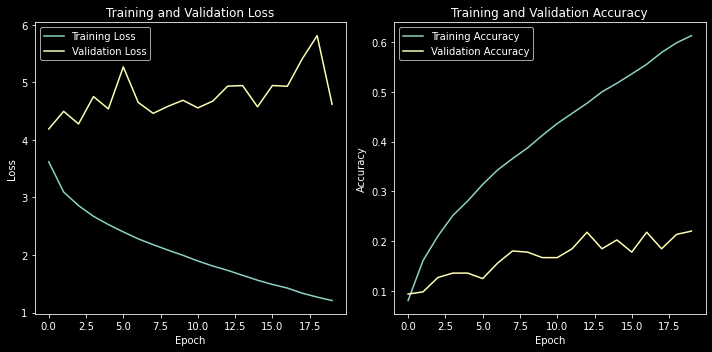

{'precision': 0.3940744073921403,
 'recall': 0.19555555555555557,
 'f1': 0.21867031200680254,
 'class_counts': [10,
  12,
  13,
  9,
  4,
  4,
  4,
  2,
  10,
  22,
  2,
  4,
  18,
  3,
  4,
  2,
  5,
  2,
  2,
  2,
  5,
  4,
  5,
  1,
  1,
  4,
  2,
  5,
  5,
  7,
  5,
  5,
  3,
  4,
  3,
  5,
  1,
  11,
  9,
  5,
  21,
  2,
  6,
  1,
  6,
  137,
  6,
  11,
  34,
  2]}

In [3]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q1_diff_ch_not_weighted/train_record/train_record_lr0.0001_bn_dropout.pkl', 'rb'))
test_record = pickle.load(open('record/Q1_diff_ch_not_weighted/test_record/test_record_lr0.0001_bn_dropout.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 20
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
test_record

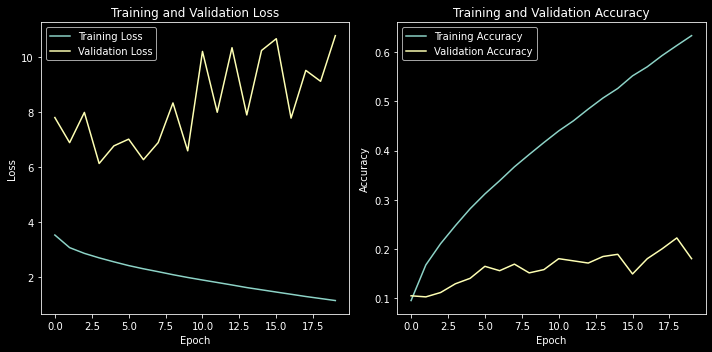

{'precision': 0.3855004129939932,
 'recall': 0.2,
 'f1': 0.221006857390608,
 'class_counts': [5,
  11,
  7,
  11,
  4,
  3,
  4,
  10,
  1,
  10,
  6,
  2,
  1,
  3,
  0,
  0,
  2,
  4,
  2,
  3,
  1,
  4,
  4,
  5,
  2,
  2,
  6,
  17,
  11,
  10,
  3,
  5,
  1,
  4,
  9,
  3,
  4,
  7,
  2,
  2,
  5,
  5,
  3,
  1,
  5,
  197,
  5,
  2,
  33,
  3]}

In [4]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q1_diff_ch/train_record/train_record_lr0.0001_bn_dropout.pkl', 'rb'))
test_record = pickle.load(open('record/Q1_diff_ch/test_record/test_record_lr0.0001_bn_dropout.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 20
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
test_record

In [105]:
import torch

# 创建示例张量
tensor = torch.tensor([[1, 0, 1], [1, 1, 1]])

# 计算每行中1的数量
ones_count = tensor.sum(dim=1, keepdim=True)  # 按行求和，并保持维度以便广播

# 除以每行中1的数量，然后乘以3
result = (tensor.float() / ones_count.float()) * 3
y = result.view(result.size(0), result.size(1), 1, 1)
print(y)  # 重新展平张量以便查看结果
x = torch.randn(2, 3, 2, 2)
print(x)
print(x*y)

tensor([[[[1.5000]],

         [[0.0000]],

         [[1.5000]]],


        [[[1.0000]],

         [[1.0000]],

         [[1.0000]]]])
tensor([[[[ 0.2955, -0.4718],
          [-1.1016, -0.2437]],

         [[-1.7168,  1.1007],
          [-0.4078,  0.2791]],

         [[-0.2546,  0.2002],
          [-0.5150, -0.1741]]],


        [[[-0.2852, -1.3787],
          [ 0.3668, -0.4945]],

         [[ 1.7914,  1.3040],
          [ 0.8940,  0.5679]],

         [[ 1.0277, -0.6686],
          [ 0.3389, -1.4921]]]])
tensor([[[[ 0.4432, -0.7076],
          [-1.6524, -0.3656]],

         [[-0.0000,  0.0000],
          [-0.0000,  0.0000]],

         [[-0.3819,  0.3002],
          [-0.7725, -0.2611]]],


        [[[-0.2852, -1.3787],
          [ 0.3668, -0.4945]],

         [[ 1.7914,  1.3040],
          [ 0.8940,  0.5679]],

         [[ 1.0277, -0.6686],
          [ 0.3389, -1.4921]]]])


In [22]:
a = torch.randn(2, 3, 2, 2)
print(a)
x = torch.tensor([[1, 0, 1], [1, 1, 1]]).unsqueeze(-1).unsqueeze(-1)
print(a.masked_fill(x == 0, float('-inf')))


tensor([[[[ 1.7132, -0.3889],
          [-0.8035, -0.6953]],

         [[ 0.4970, -0.9379],
          [ 2.0081, -1.5855]],

         [[ 0.8488,  0.7728],
          [-0.2615,  1.8175]]],


        [[[-0.3718, -0.6230],
          [-1.1075, -0.3085]],

         [[ 0.3263, -1.1688],
          [ 0.1080,  1.3772]],

         [[ 0.1689, -0.0219],
          [-0.4940,  1.1100]]]])
tensor([[[[ 1.7132, -0.3889],
          [-0.8035, -0.6953]],

         [[   -inf,    -inf],
          [   -inf,    -inf]],

         [[ 0.8488,  0.7728],
          [-0.2615,  1.8175]]],


        [[[-0.3718, -0.6230],
          [-1.1075, -0.3085]],

         [[ 0.3263, -1.1688],
          [ 0.1080,  1.3772]],

         [[ 0.1689, -0.0219],
          [-0.4940,  1.1100]]]])


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class CustomConv(nn.Module):
    def __init__(self, out_channels, img_size, kernel_size):
        super(CustomConv, self).__init__()

        self.linear_R = nn.Linear(img_size*img_size, 1)
        self.linear_G = nn.Linear(img_size*img_size, 1)
        self.linear_B = nn.Linear(img_size*img_size, 1)

        self.conv = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        
    def forward(self, x, open_channels):
        batch_size, channels, height, width = x.size()
        # Flatten each channel
        x_flattened = x.view(batch_size, channels, -1)  # Shape: (batch_size, channels, height*width)
        weight_R = self.linear_R(x_flattened[:, 0, :])
        weight_G = self.linear_G(x_flattened[:, 1, :])
        weight_B = self.linear_B(x_flattened[:, 2, :])
        kernel_weight = torch.stack([weight_R, weight_G, weight_B]).permute(1, 0, 2) 
        kernel_masked = kernel_weight.masked_fill(open_channels.unsqueeze(-1) == 0, float('-inf'))
        kernel_masked = F.softmax(kernel_masked, dim=1)
        print(kernel_masked)
        out = self.conv(x*kernel_masked.unsqueeze(-1))
        return out

# class CustomConv(nn.Module):
#     def __init__(self, out_channels, img_size, kernel_size):
#         super(CustomConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2)
#         
#     def forward(self, x, open_channels):
#         batch_size, channels, height, width = x.size()
#         # Flatten each channel        
#         ones_count = open_channels.sum(dim=1, keepdim=True)  # Count the number of 1s in each row
#         multiplier = (open_channels.float() / ones_count.float()) * 3  # Calculate the multiplier for each row
#         multiplier = multiplier.view(multiplier.size(0), multiplier.size(1), 1, 1)  # Reshape for broadcasting
#         
#         out = self.conv(x * multiplier)
# 
#         return out

model = CustomConv(out_channels=10, img_size=28, kernel_size=3)
input = torch.randn(2, 3, 28, 28)
open_channels = torch.tensor([[0, 1, 1], [4, 1, 1]])
# 示例代码用于检查CustomConv的梯度
def check_grad_custom_conv():
    # 创建模型实例和随机输入    
    # 运行前向传播和反向传播
    output = model(input, open_channels)
    loss = output.sum()  # 示例损失函数
    loss.backward()
    
    # 打印每个参数的梯度
    print("Gradient of linear_R weight:", model.linear_R.weight.grad[0][:10])

# 调用检查梯度的函数
check_grad_custom_conv()


tensor([[[0.0000],
         [0.2314],
         [0.7686]],

        [[0.2151],
         [0.4336],
         [0.3514]]], grad_fn=<SoftmaxBackward0>)
Gradient of linear_R weight: tensor([ 0.4891,  7.5962, -4.5565, -6.7676, -6.0844,  1.8841,  5.9927,  6.9858,
        -5.7685,  3.7545])


In [32]:
check_grad_custom_conv()


Gradient of linear_R weight: tensor([ 18.7358, -16.9752,  -4.4648,  -9.6570,  -5.1893, -10.0131,   5.3894,
        -19.4630,  -2.6237,  -8.8523])
